# spaCy/HDBScan Feature Extraction Pipeline

### Note: it can be quite complicated to install spaCy and sense2vec, given conflicting low-level requirements, so at this point I wouldn't suggest that others try to install the libraries and run this notebook.
  
However, it is well worth scanning down to the cell titled ***Harvesting Word Features***. In the output of that cell, there are examples of 52 feature clusters harvested by this process. The ultimate output of this process will produce a dataset containing a product ID (asin), overall rating, and word feature, for each word feature found in each product review. I don't consider these feature clusters as the final product, and we should discuss.


### We can use this output for several purposes. 

1. First, we should be able to quite easily make the data available to th web interface, so that we can display the top n word features (by overall rating) associated with products returned.

2. We will want to also include the user's selected word features in our model evaluation, to enable them to "drill into" selected features and thus explore the product/feature landscape.

3. Finally, I think it would be worth training a model on a vectorized representation of the top n most highly rated features, which may give us another dimension for predicting rating based on feature combination/interaction.

In [1]:
import pandas as pd
import gzip
import time
# Install a few python packages using pip
from common import utils
utils.require_package("wget")      # for fetching dataset

In [10]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
import itertools

# Numerical manipulation libraries.
import numpy as np

#Visualization
import matplotlib
%matplotlib inline

import spacy
#activated = spacy.prefer_gpu()

import hdbscan
import seaborn as sns
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
from spacy.tokens import Doc
import tqdm

In [4]:
plotting = True
labels_words = False

language_model = 'en_core_web_md'


start = time.time()
print("Reading English core web medium language data using spaCy...")
nlp = spacy.load(language_model)
print("...finished reading English language model '{}' in {} seconds.".format(language_model, time.time()-start))


Reading English core web medium language data using spaCy...
...finished reading English language model 'en_core_web_md' in 12.893219947814941 seconds.


In [5]:
debug = False

lemmas = {}
ignore_words = []


path_for_tf_metadata = './logdir/embedding_test'
path_for_tf_ckpt = path_for_tf_metadata+'/embedding_test.ckpt'
vectors_filepath = './data/vectors_each.tsv'
metadata_filepath = './data/metadata_each.tsv'


In [6]:
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')

start = time.time()
print("Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...")
df = getDF('./data/reviews_Toys_and_Games_5.json.gz')
print("...read reviews_Toys_and_Games_5.json.gz in {} seconds.".format(time.time()-start))

Reading Pandas dataframe from reviews_Toys_and_Games_5.json.gz...
start getDF
start parse
end parse with time for parse 7.405748128890991
end getDF
time taken to load data =  7.406217098236084
...read reviews_Toys_and_Games_5.json.gz in 9.916450023651123 seconds.


In [7]:
print(df.shape)
print(df.columns)
df.head(2)

(167597, 9)
Index(['summary', 'unixReviewTime', 'reviewerName', 'helpful', 'reviewText',
       'asin', 'reviewTime', 'overall', 'reviewerID'],
      dtype='object')


,summary,unixReviewTime,reviewerName,helpful,reviewText,asin,reviewTime,overall,reviewerID
0,Magnetic board,1390953600,Angie,"[0, 0]",I like the item pricing. My granddaughter want...,0439893577,"01 29, 2014",5.0,A1VXOAVRGKGEAK
1,it works pretty good for moving to different a...,1395964800,Candace,"[1, 1]",Love the magnet easel... great for moving to d...,0439893577,"03 28, 2014",4.0,A8R62G708TSCM


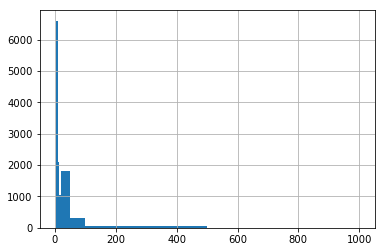

In [8]:
#Number of reviews by product
cnt_by_product = df[['asin','reviewText']].groupby('asin').agg('count')
cnt_by_product['reviewText'].hist(bins = [0,1,2,3,4,5,10,15,20,50,100,500,1000])

In [16]:
def consume_suspect_tokens(text, nlp, ignore_words, lemmas, ignore_initial=False):
    """ Parse text and return ignored words at the begining of the phrase, along with the valid phrase (if any)
    at the end of the phrase token.
    
    Args
    ----------
    ignore_initial (boolean) indicator of whether to ignore the first word in the phrase token (when a recursive call)
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    ignore_words (list)      collected set of words to be ignored, to which this function may add words
    lemmas (dict)            dict of word->
    
    Returns:
    ----------
    None
    """
    if ignore_initial:
        token_parts = text.split(" ")
        first_word = token_parts[0]
        
        if first_word not in ignore_words:
            ignore_words.append(first_word)
            #print("Ignoring word '{}' in feature extraction...".format(first_word))    
        
        if (" " in text) and (len(text.split(" "))>1):
            text = " ".join(token_parts[1:])
        else:
            return None

    doc = nlp(text)
    
    for token in doc:
        if debug:
            print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop, [child for child in token.children])
        lower_token = token.text.lower()
        if (lower_token is not None):
            if (lower_token not in ignore_words):
                if (token.lemma_ in IGNORED_LEMMAS) or (token.pos_ in IGNORED_POS):
                    consume_suspect_tokens(text, nlp, ignore_words, lemmas, ignore_initial=True)
                else:
                    lemmas[token.text] = lower_token
                
        return None


def get_vectors(text, nlp, ignore_words, lemmas):
    """ <generator> Get embedding word vectors from a given text object. 
    Args
    ----------
    text (string)            text to be parsed, tokenized, and vectorized
    nlp (spaCy pipeline)     pipeline to use for processing the input text
    ignore_words (list)      collected set of words to be ignored, to which this function may add words
    lemmas (dict)            dict of word->
    
    Generates:
    ----------
    processed text (string) 
    phrase vector (numpy.ndarray)
    """
    
    chunks_seen = []
    consume_suspect_tokens(text, nlp, ignore_words, lemmas)
              
    doc = nlp(text)
    #####
    # Next, iterate through the sentences and within those the noun chunks.
    # These noun chunks will be lemmatized and collected as potential features.
    #####
    for sent in doc.sents:
        for chunk in sent.noun_chunks:
           
            if chunk.text not in chunks_seen:
                chunks_seen.append(chunk.text)
                processed_text = chunk.text
                
                lemmatized_tokens = []
                
                if lemmas is not None:
                    
                    for chunk_token in chunk.text.split(' '):
                        lower_token = chunk_token.lower()
                        if (ignore_words is None) or (lower_token not in ignore_words):
                            
                            try:
                                this_lemma = lemmas[lower_token]
                            except:
                                this_lemma = lower_token
                                
                            lemmatized_tokens.append(this_lemma)
                            
                    if len(lemmatized_tokens)>0:
                        processed_text = " ".join(lemma for lemma in lemmatized_tokens)
                    else:
                        continue
                    
                yield processed_text, chunk.vector
    

In [17]:
def write_vectors(product, rating, concept_vec):
    """Write product, rating, phrase and sense vector to file"""
    
    with open(vectors_filepath, 'a') as out_v, open(metadata_filepath, 'a') as out_m:
        phrase = concept_vec[0]
        sense_vector = concept_vec[1]
        out_m.write('{}\t{}\t{}\n'.format(product, str(rating),phrase))
        out_v.write('\t'.join([str(x) for x in sense_vector]) + "\n")


In [18]:
#Number of reviews by reviewer
cnt_by_reviewer = df[['reviewerID','reviewText']].groupby('reviewerID').agg('count').reset_index()

good_reviewers = cnt_by_reviewer[cnt_by_reviewer['reviewText']>4]
print(good_reviewers[:5])

good_products = cnt_by_product[cnt_by_product['reviewText']>4].reset_index()
print(good_products[:5])

              reviewerID  reviewText
0  A012468118FTQAINEI0OQ           6
1   A0182108CPDLPRCXQUZQ           8
2  A026961431MGW0616BRS3           6
3  A034597326Z83X79S50FI           7
4  A04295422T2ZG087R17FX           5
         asin  reviewText
0  0439893577          17
1  048645195X          11
2  0545496470           6
3  0615444172           6
4  0670010936          10


In [20]:
# Here are the controls for ignored words in the review
IGNORED_LEMMAS = ['-PRON-']
IGNORED_POS = ['PUNCT', 'SPACE', 'PART', 'DET']

write_to_file = True

!rm -f ./vectors_each.tsv
!rm -f ./metadata_each.tsv

sample_vect = [vec for vec in get_vectors("example", nlp, ignore_words, lemmas)][0][1]
vect_dim = sample_vect.shape
print("Sample vect[{}]".format(vect_dim))
index = []
output = None

total_start = time.time()

good_reviews = df[df['reviewerID'].isin(good_reviewers['reviewerID'])][df['asin'].isin(good_products['asin'])]

print("There are {} total reviews for reviewers with at least 5 reviews each and products with at least 5 reviews each".format(len(good_reviews)))

iteration_size = 200
#iter_limit = len(good_reviews)
iter_limit = 1001


print("\nCollecting word concept vectors for {} reviews...".format(iter_limit))

for iteration in range(int(iter_limit/iteration_size)):

    print("Starting iteration over reviews {}-{}...".format(iteration*iteration_size,
                                                            (iteration+1)*iteration_size))
    iter_start_time = time.time()

    for iter_ind in range(iteration_size):
    
        review_ind = iteration*iteration_size + iter_ind
        
        reviewer = good_reviews['reviewerID'].iloc[review_ind]
        product = good_reviews['asin'].iloc[review_ind]
    
        rating = good_reviews['overall'].iloc[review_ind]
        review = good_reviews['reviewText'].iloc[review_ind]
    
        #print(review)
        for concept_vec in get_vectors(review, nlp, ignore_words, lemmas):
            
            if write_to_file:
                # Append data to files for later reading
                write_vectors(product, rating, concept_vec)
            else:
                # Append data to a list and a numpy array
                index.append([product, rating, concept_vec[0]])
        
                if output is None:
                    # Create an np.array with the first row as the retrieved word vector
                    output = np.array([concept_vec[1]])
                else:
                    # Append the next vector to the end of the vectors array
                    output = np.append(output, np.array([concept_vec[1]]), axis=0)            

    print("...completed processing {} reviews in {} seconds.".format(iteration_size, time.time()-iter_start_time))
    
print("...Collected {} word vectors in {} seconds.".format(iteration*iteration_size, time.time()-total_start))


Sample vect[(300,)]
There are 167597 total reviews for reviewers with at least 5 reviews each and products with at least 5 reviews each

Starting iteration over reviews 0-200...
...completed processing 200 reviews in 12.119228839874268 seconds.
Starting iteration over reviews 200-400...
...completed processing 200 reviews in 14.87395691871643 seconds.
Starting iteration over reviews 400-600...
...completed processing 200 reviews in 12.465951919555664 seconds.
Starting iteration over reviews 600-800...
...completed processing 200 reviews in 15.583565950393677 seconds.
Starting iteration over reviews 800-1000...
...completed processing 200 reviews in 12.564543008804321 seconds.
...Collected 800 word vectors in 67.73524498939514 seconds.


In [23]:
import tqdm

def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

vdim = file_len(vectors_filepath)
print("vectors file contains {} lines".format(vdim))
index = []
output = None

sample_prob=0.01
# Generate random samples set, used for both the vectors file and the metadata file so the elements match
samples = np.random.choice(a=[True,False], size=vdim, p=[sample_prob,1.0-sample_prob])
print("This sample probability will include {} samples from the generated sense vectors.".format(sum(samples)))

vectors file contains 957864 lines
This sample probability will include 9621 samples from the generated sense vectors.


In [24]:
# Read the vectors file back in, in case you want to restart from here.

with open(vectors_filepath, 'r') as in_v:
    print('File {} contains {} sense vectors.'.format(vectors_filepath, vdim))
    curr_line = 0
    t = tqdm.tqdm(total=vdim)
    
    for line in in_v:
        sample_this_row = samples[curr_line]
        
        if sample_this_row:
            if output is None:
                # Create an np.array with the first row as the retrieved word vector
                output = np.array([np.array(line.split('\t'))])
            else:
                # Append the next vector to the end of the vectors array
                output = np.append(output, np.array([np.array(line.split('\t'))]), axis=0)
                
        curr_line += 1
        t.update()
        #if len(output)>2:        
        #    break
    t.close()


print("Output shape: {}".format(output.shape))


  1%|          | 9413/957864 [00:00<00:10, 94129.19it/s]

File ./data/vectors_each.tsv contains sense vectors of dimension 957864


100%|██████████| 957864/957864 [06:35<00:00, 2419.41it/s] 

Output shape: (9621, 300)


In [44]:
# Fit an HDBScan model using the sampled sense vectors

HDBSCAN_METRIC = 'manhattan'

start = time.time()
print("Creating word clusters from word vectors...")
hdbscanner = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, 
                             metric=HDBSCAN_METRIC, gen_min_span_tree=True, prediction_data=True)
hdbscanner.fit(output)
print("...completed clustering in {} seconds.".format(time.time()-start))


import pickle 
with open('./data/hdbscanner.{}.pickle'.format(len(output)), 'wb') as pickle_file:
    pickle.dump(hdbscanner, pickle_file)

Creating word clusters from word vectors...


/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)
/Users/burgew/miniconda3/envs/spacy3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:558: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


...completed clustering in 57.96712398529053 seconds.


Condensing the linkage tree and then plotting...
...plotted condensed tree in 2.2661709785461426 seconds.
Found 115 clusters


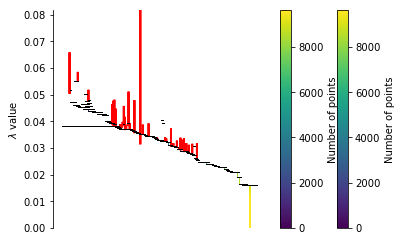

In [45]:
# Plot the condensed cluster tree

if plotting:
	start = time.time()
	print("Condensing the linkage tree and then plotting...")
	#hdbscanner.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
	hdbscanner.condensed_tree_.plot()
	hdbscanner.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
	print("...plotted condensed tree in {} seconds.".format(time.time()-start))
	tree = hdbscanner.condensed_tree_
	print("Found {} clusters".format(len(tree._select_clusters())))
	matplotlib.pyplot.show()

In [46]:
def exemplars(cluster_id, condensed_tree):
    """ Collect and return the exemplar words for each cluster. """
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree['child_size'] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree['lambda_val'][raw_tree['parent'] == leaf].max()
        points = raw_tree['child'][(raw_tree['parent'] == leaf) & 
                                   (raw_tree['lambda_val'] == max_lambda)]
        result = np.hstack((result, points))
    return result.astype(np.int)

In [47]:
tree = hdbscanner.condensed_tree_

#print('Index, for reference:')
#for ind, entry in enumerate(index):
#    print("cluster: {}, ind: {}, entry: {}".format(hdbscanner.labels_[ind], ind, entry))

start = time.time()
print("Selecting clusters in tree...")
clusters = tree._select_clusters()
print("...finished selecting clusters in {} seconds.".format(time.time()-start))

initial_cluster_count = len(clusters)
print("Found {} clusters".format(initial_cluster_count))

all_points = []
labels = []

# iterate through the input metadata once, to collect all words and the labels for the sampled points
with open(metadata_filepath, 'r') as in_m, open(path_for_tf_metadata+'/metadata.tsv', 'w') as out_tf_meta:
	mdim = None
	curr_line = 0
	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains index entries of of dimension {}'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		all_points.append(line.split('\t'))
		sample_this_row = samples[curr_line]
		if sample_this_row:
			meta_line = line.split('\t')
			index.append(meta_line)
			if labels_words:
				labels.append(meta_line[2])
		curr_line += 1

print("Index({}, {}): {}".format(len(index), len(index[0]), index[:5]))

print("All Points({}, {}): {}".format(len(all_points), len(all_points[0]), all_points[:5]))

# then, iterate through the input metadata again, to apply the cluster labels, if labels_words is False
with open(metadata_filepath, 'r') as in_m, open(path_for_tf_metadata+'/metadata.tsv', 'w') as out_tf_meta:
	mdim = None
	curr_line = 0
	curr_sample = 0

	for line in in_m:
		if mdim is None:
			mdim = line.count('\t')+1
			print('File {} contains {} index entries.'.format(metadata_filepath, vdim))
		if line.endswith('\n'):
			line = line[:-1]
		sample_this_row = samples[curr_line]
		if sample_this_row:
			index.append(line.split('\t'))
			if not labels_words:
				labels.append("-")
			curr_sample += 1
		curr_line += 1


Selecting clusters in tree...
...finished selecting clusters in 0.020389080047607422 seconds.
Found 115 clusters
File ./data/metadata_each.tsv contains index entries of of dimension 957864
Index(28863, 3): [['0439893577', '4.0', 'it'], ['048645195X', '5.0', 'these designs'], ['0615444172', '5.0', 'best incentive'], ['0735321396', '4.0', 'grandson'], ['0735321396', '5.0', 'it']]
All Points(957864, 3): [['0439893577', '5.0', 'i'], ['0439893577', '5.0', 'item pricing'], ['0439893577', '5.0', 'granddaughter'], ['0439893577', '5.0', 'it'], ['0439893577', '5.0', 'letters']]
File ./data/metadata_each.tsv contains 957864 index entries.


In [48]:
selected_clusters = []

for i, c in enumerate(clusters):
	c_exemplars = exemplars(c, tree)

	point_label = None
	cluster_exemplars = set()
	for ind, ex_ind in enumerate(c_exemplars):
		#print("Exemplar -- {} : {}".format(index[ex_ind][0], index[ex_ind][2]))
		cluster_exemplars.add(index[ex_ind][2])
		if point_label is None:
			point_label = index[ex_ind][2]
    
	members = set()
	for label_ind, label in np.ndenumerate(hdbscanner.labels_):
		if label == i:
			members.add(index[label_ind[0]][2])
			if not labels_words:
				labels[label_ind[0]] = point_label
            
            #print("Member: {} : {}".format(index[label_ind[0]][0], index[label_ind[0]][2]))
    
	exemplars_len = float(len(cluster_exemplars))
	members_len = float(len(members))
    
    # Look for clusters where the members outnumber the exemplars by 2 times
	if ((exemplars_len>0) and (len(members)>(2.0*exemplars_len))):
    
		example_cluster_exemplars = ", ".join(cluster_exemplars)
		example_cluster_members = ", ".join(members)
        
		selected_clusters.append([example_cluster_exemplars, example_cluster_members])

selected_cluster_count = len(selected_clusters)
if (selected_cluster_count>0):
    print("\nFound {} clusters ({}% of initially collected):".
          format(len(selected_clusters), 100.0*float(selected_cluster_count)/float(initial_cluster_count)))
    for example in selected_clusters:
        print("\nExemplars: {}".format(example[0]))
        print("Members: {}".format(example[1]))

with open(path_for_tf_metadata+'/metadata.tsv', 'w') as out_tf_meta:
	for label in labels:
		out_tf_meta.write(str(label)+'\n')
                                                                    
noise_count = sum([1 for label in hdbscanner.labels_ if label == -1])
print("\nThere were {} words that were considered noise.".format(noise_count))



Found 20 clusters (17.391304347826086% of initially collected):

Exemplars: anyone
Members: anyone, anybody, most anyone

Exemplars: elf
Members: doll, their elf, your elf, elf doll, elf, our elf

Exemplars: colors
Members: same color, colors, color, six colors, those colors, one color, only one color

Exemplars: my daughter, daughter
Members: my daughter, youngest daughter, granddaughter, sister, daughters, niece, daughter

Exemplars: rulebook, rules
Members: basic rules, rules, complicated rules, rule, new rules, rulebook

Exemplars: the cards, cards
Members: right cards, title card, each card set, more cards, that card, card/deck version, question cards, one card, cards, same cards, two new cards, card loving role, all those cards, most cards, card, larger cards, that one card, several cards, some cards, single card, three cards, question card, these cards, lucky card, card game--, six cards, two cards, destination cards, the cards, four cards, every card, five new cards, each card

In [49]:
# Prepare for a tensorboard visualization

import tensorflow as tf

output_init = tf.constant_initializer(output)

print('fitting shape:')
tf.reset_default_graph()
with tf.Session() :
    embedding_var = tf.get_variable('embedding_var', shape=[len(output), len(output[0])], initializer=tf.constant_initializer(output), dtype=tf.float32)
    embedding_var.initializer.run()
    print(embedding_var.eval())
    
sess = tf.Session()

sess.run(embedding_var.initializer)


with open(path_for_tf_ckpt,'w') as f:
    f.write("Index\tLabel\n")
    for ind,label_line in enumerate(index):
        label = '{}:{}:{}'.format(label_line[0], label_line[1], label_line[2])
        f.write("%d\t%s\n" % (ind,label))


fitting shape:
[[ 0.0013629   0.35653    -0.055497   ... -0.11237     0.078259
   0.22398   ]
 [-0.0809065  -0.013005   -0.3085235  ...  0.0526415   0.34908497
   0.02017   ]
 [ 0.13602    -0.031015   -0.0942     ...  0.065075   -0.091585
   0.06615   ]
 ...
 [-0.1542365   0.04899999 -0.210735   ...  0.2158745   0.2701
  -0.217215  ]
 [-0.00740667 -0.07764267 -0.18821    ... -0.06809667  0.11845332
  -0.25808   ]
 [ 0.23648     0.39091    -0.095802   ...  0.13228     0.36417
  -0.28676   ]]


In [50]:
# Generate the tensorboard embedding visualization
# To view it, run command "tensorboard --port=6006 --logdir=./logdir" on your computer and then 
# open http://localhost:6006 in a browser.

from tensorflow.contrib.tensorboard.plugins import projector

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    # Create summary writer.
    writer = tf.summary.FileWriter(path_for_tf_metadata, sess.graph)
    # Initialize embedding_var
    sess.run(embedding_var.initializer)
    # Create Projector config
    config = projector.ProjectorConfig()
    # Add embedding visualizer
    embedding = config.embeddings.add()
    # Attache the name 'embedding'
    embedding.tensor_name = embedding_var.name
    # Metafile which is described later
    embedding.metadata_path = 'metadata.tsv'
    # Add writer and config to Projector
    projector.visualize_embeddings(writer, config)
    # Save the model
    saver_embed = tf.train.Saver([embedding_var])
    saver_embed.save(sess, path_for_tf_ckpt, 1)

writer.close()

In [51]:
def generate_sample_vectors(text, nlp, ignore_words, lemmas):
    """ Preprocess test text content, for predicting labels."""
    
    sample_index = []
    sample_vectors = None
    
    for concept_vec in get_vectors(text, nlp, ignore_words, lemmas):
            
        # Append data to a list and a numpy array
        sample_index.append([product, rating, concept_vec[0]])
        
        if sample_vectors is None:
            # Create an np.array with the first row as the retrieved word vector
            sample_vectors = np.array([concept_vec[1]])
        else:
            # Append the next vector to the end of the vectors array
            sample_vectors = np.append(sample_vectors, np.array([concept_vec[1]]), axis=0)            
    
    return sample_index, sample_vectors

In [70]:
def get_sample_labels(cluster_ind):
    sample_labels = set()
    for word_ind in exemplars(clusters[cluster_ind], tree):
        sample_labels.add(index[word_ind][2])
        
    return sample_labels

In [79]:
sample_text = "I would buy this again. It was a very good deal and good for children 2-4. Usually, this is good fun and good for the whole family, brothers, sisters and friends. Another with a magnetic personality was buying sweets for his sweet. Something should be done to handle all shapes and sizes and enable then to be put together."

sample_index, sample_vectors = generate_sample_vectors(sample_text, nlp, ignore_words, lemmas)

test_labels, strengths = hdbscan.approximate_predict(hdbscanner, sample_vectors)
print("test_labels: ",test_labels)

for ind, word_index in enumerate(sample_index):
    if (test_labels[ind] >0):
        print("Phrase '{}' is predicted to have labels {}.".format(word_index[2], get_sample_labels(test_labels[ind])))

test_labels:  [ 1 90 -1 19 -1 59 -1 -1 31 -1 -1]
Phrase 'i' is predicted to have labels {'i'}.
Phrase 'it' is predicted to have labels {'it'}.
Phrase 'children' is predicted to have labels {'children'}.
Phrase 'whole family' is predicted to have labels {'original version', 'addams family', 'family', 'whole family', 'old version', 'family version', 'version'}.
Phrase 'something' is predicted to have labels {'something'}.
